In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



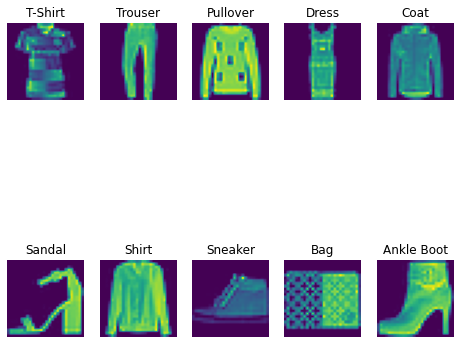

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 2
for i in range(10):
    training_data_i = training_data.data[training_data.targets==i]
    img = training_data_i[torch.randint(0, len(training_data_i), (1, )).item()]
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels_map[i])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [4]:
class Linear():
  def __init__(self,in_features, out_features)-> None:
        self.weight = torch.randn(in_features,out_features, device=device, requires_grad=True)
        self.bias =torch.randn(1,out_features, device=device, requires_grad=True)
  def __call__(self,input):
        return torch.matmul(input,self.weight)+ self.bias
class ReLU():

  def __call__(self,x):
        return torch.clamp(x, min=0)     
class softmax(): 
  
  def __call__(self,x):
        x_exp = x-torch.mean(x, dim=1, keepdim=True)
        x_sum_exp= torch.logsumexp(x_exp, dim=1, keepdim=True)
        return x_exp - x_sum_exp
  
class Model():
    def __init__(self):
        self.linear1 = Linear(28*28, 512)
        self.relu1 = ReLU()
        self.linear2 = Linear(512, 512)
        self.relu2 = ReLU()
        self.linear3 = Linear(512, 10)
        self.softmax1 = softmax()
    def __call__(self, x):
        x= self.linear1(x)
        x= self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.softmax1(x)
        return x

In [5]:
# creating an instance of our model
model = Model()

torch.manual_seed(42)

x = torch.rand(16, 28*28).to(device)
model(x)

tensor([[     0.0000,  -6097.9771,  -6951.5400,  -9709.4141, -10357.8672,
          -1449.3755, -11740.4980, -13193.8145,  -3841.5684,  -5754.3291],
        [ -1819.9585,  -7139.2871,  -6560.8525,  -9460.3730,  -8174.9390,
              0.0000, -16977.1699, -16691.8926,  -5891.2422,  -4757.8140],
        [     0.0000,  -2722.2183,  -2415.7935,  -7436.1748,  -6037.4365,
           -140.2168,  -7814.9072, -15912.6572,  -5077.7920,  -3550.2476],
        [     0.0000,  -2452.9053,  -7451.2480,  -8095.9111, -10265.1318,
          -5798.5537, -11864.9990, -15319.6992,  -3762.1245,  -3200.7715],
        [     0.0000,  -3893.8486,  -1161.1362,   -524.6357,  -7745.1104,
          -1956.0750,  -6597.0166, -14016.8340,  -3765.7751,  -2491.5823],
        [     0.0000,  -4226.1782,  -5197.7021,  -8794.6133,  -9603.6064,
          -2446.1572, -14186.1758, -22531.6758,  -6338.8711,  -6320.3799],
        [  -657.0098,  -3443.5381,  -5855.0317, -10426.3594,  -7087.0078,
              0.0000,  -9098.006

In [6]:
def cross_entropy_loss(pred,y):

    loss = -torch.sum(y * pred) / (y * pred).shape[0]
    
    return loss


In [7]:
def train_loop(dataloader, model,lr):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        X = X.squeeze().reshape(len(X),784)
        pred = model(X)
        loss = cross_entropy_loss(pred, y)

        # Backpropagation

        loss.backward()

        with torch.no_grad():
            model.linear1.weight-=lr*model.linear1.weight.grad
            model.linear1.bias-=lr*model.linear1.bias.grad
            model.linear2.weight-=lr*model.linear2.weight.grad
            model.linear2.bias-=lr*model.linear2.bias.grad
            model.linear3.weight-=lr*model.linear3.weight.grad
            model.linear3.bias-=lr*model.linear3.bias.grad
        model.linear1.weight.grad.zero_()  
        model.linear1.bias.grad.zero_()  
        model.linear2.weight.grad.zero_()  
        model.linear2.bias.grad.zero_()  
        model.linear3.weight.grad.zero_()  
        model.linear3.bias.grad.zero_()  

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.squeeze().reshape(len(X),784)
            pred = model(X)
            train_loss += cross_entropy_loss(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")


def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.squeeze().reshape(len(X),784)
            pred = model(X)
            test_loss += cross_entropy_loss(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [8]:
training_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),
target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y)
, value=1)))
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),
target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y)
, value=1)))


In [9]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
lr = 0.001
epochs = 8
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, lr)
    test_accuracy = test_loop(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 4798.488770  [    0/60000]
loss: 501.678345  [ 6400/60000]
loss: 249.056015  [12800/60000]
loss: 237.991501  [19200/60000]
loss: 136.023254  [25600/60000]
loss: 152.103943  [32000/60000]
loss: 144.307846  [38400/60000]
loss: 169.171631  [44800/60000]
loss: 144.487656  [51200/60000]
loss: 144.653397  [57600/60000]
Train Error: 
 Accuracy: 78.5%, Avg loss: 107.024426 

Test Error: 
 Accuracy: 76.7%, Avg loss: 123.972700 

Epoch 2
-------------------------------
loss: 83.286255  [    0/60000]
loss: 158.476562  [ 6400/60000]
loss: 58.651535  [12800/60000]
loss: 98.431442  [19200/60000]
loss: 73.979050  [25600/60000]
loss: 78.971497  [32000/60000]
loss: 64.686607  [38400/60000]
loss: 76.194992  [44800/60000]
loss: 50.980473  [51200/60000]
loss: 64.586899  [57600/60000]
Train Error: 
 Accuracy: 81.6%, Avg loss: 67.837465 

Test Error: 
 Accuracy: 79.1%, Avg loss: 85.655979 

Epoch 3
-------------------------------
loss: 39.230095  [    0/60000]
l

In [11]:
 print(f" Final Test Accuracy: {(100*test_accuracy):>0.1f}%")

 Final Test Accuracy: 80.6%


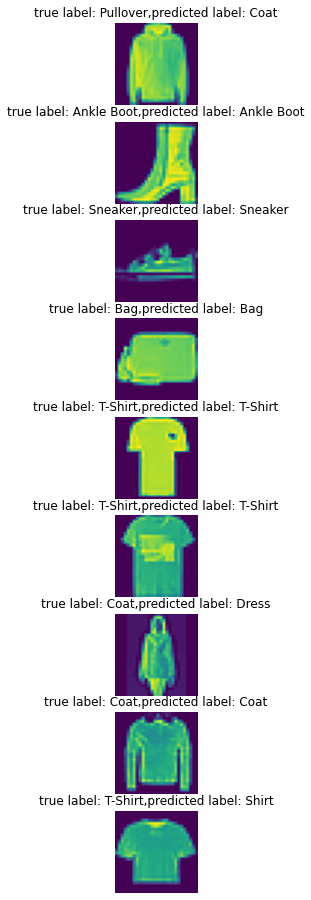

In [12]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(16, 16))
cols, rows = 1, 9
for i in range(9):
    X,y=training_data[torch.randint(0, len(training_data), (1, )).item()]
    X, y = X.to(device), y.to(device)
    X = X.squeeze().reshape(len(X),784)
    pred = model(X)
    figure.add_subplot(rows, cols, i+1)
    plt.title("true label: " + labels_map[y.argmax(0).item()] + ",predicted label: " + labels_map[pred.argmax(1).item()])
    plt.axis("off")
    plt.imshow(X.reshape(28,28).cpu().detach().numpy())
plt.show()